In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def analyze_cell_lines(cell_lines_times):
    for cell_line_time in cell_lines_times:
        # Load data
        counts, deseq, desingle = load_data(cell_line_time)

        # Preprocess data
        expr_single, expr_pseudo, deseq, lfc_single, lfc_pseudo, desingle = \
        preprocess_data(counts, deseq, desingle)

        # Plot and save data
        plot_data(expr_single, expr_pseudo, deseq, lfc_single, lfc_pseudo, desingle,
                 cell_line_time)

In [11]:
def plot_data(single, pseudo, deseq, lfc_single, lfc_pseudo, desingle,
             figure_name):
    fig, axs = plt.subplots(5, 2, figsize=(16, 80))
    fig.suptitle(figure_name)

    fig.subplots_adjust(hspace=0.6)
    for i in range(5): 
        
        expr_single = single[single[first_col_name] == single[first_col_name][i]]
        expr_pseudo = pseudo[pseudo[first_col_name] == pseudo[first_col_name][i]]
    
    
        lfc_s = desingle[desingle.index.isin(lfc_single)].log2FoldChange[i]
        lfc_s = round(lfc_s, 3)
    
        ax1 = axs[i][0]
        #ax1.set_title(f'DEsingle, key_0={lfc_s}')
        ax1.set_title(lfc_s)
        sns.barplot(expr_single, x=first_col_name, y='value', hue='var', ax=ax1)
    
    
        lfc_p = deseq[deseq.index.isin(lfc_pseudo)].log2FoldChange[i] # lfc of ith gene in pseudobulk
        lfc_p = round(lfc_p, 3)
    
        ax2 = axs[i][1]
        #ax2.set_title(f'Pseudobulk, key_0={lfc_p}')
    
        ax2.set_title(lfc_p)
        sns.barplot(expr_pseudo, x=first_col_name, y='value', hue='var', ax=ax2)
    fig.savefig(f'output_graphs/{figure_name}.jpeg')

In [12]:
def load_data(cell_line_time):
    # Load the three datasets for the given cell line
    counts = rename_first_column(pd.read_csv(f"{cell_line_time}/counts.csv"))
    deseq = rename_first_column(pd.read_csv(f"{cell_line_time}/deseq.csv"))
    desingle = rename_first_column(pd.read_csv(f"{cell_line_time}/desingle.csv"))
    
    return counts, deseq, desingle

In [13]:
first_col_name = 'gene_id'
def rename_first_column(df):
    first_column_name = df.columns[0]
    df = df.rename(columns={first_column_name: first_col_name})
    return df

In [14]:
def preprocess_data(counts, deseq, desingle):
    # Preprocess the data
    
    # DEsingle preprocessing
    desingle = desingle[(desingle['pvalue.adj.FDR'] < 0.01) & (desingle['norm_foldChange'].abs() > 0.5)]
    desingle_copy = desingle.copy()
    desingle_copy.loc[:, 'log2FoldChange'] = np.log2(desingle_copy['norm_foldChange'])
    desingle = desingle_copy
    desingle = desingle.sort_values(by='log2FoldChange', ascending=False, key=abs)
    top_single = desingle.head(5).index
    
    # DESeq preprocessing
    deseq = deseq[(deseq['padj'] < 0.01)]
    deseq = deseq.sort_values(by='log2FoldChange', ascending=False, key=abs)
    deseq.index = deseq[first_col_name]
    top_pseudo = deseq.head(5).index
    
    # Filter counts for top_single and top_pseudo
    expr_single = counts[counts[first_col_name].isin(top_single)].copy()
    expr_pseudo = counts[counts[first_col_name].isin(top_pseudo)].copy()
    
    # do melting and grouping
    expr_pseudo = expr_pseudo.melt(first_col_name)
    expr_pseudo['var'] = expr_pseudo['variable'].apply(
        lambda x: 'mock' if '-mock-' in x else 
        'S2' if '-S2-' in x else None)
    
    expr_single = expr_single.melt(first_col_name)
    expr_single['var'] = expr_single['variable'].apply(
        lambda x: 'mock' if '-mock-' in x else 
        'S2' if '-S2-' in x else None)
    
    lfc_single = expr_single[first_col_name].iloc[0:5]
    lfc_pseudo = expr_pseudo[first_col_name].iloc[0:5]
    
    return expr_single, expr_pseudo, deseq, lfc_single, lfc_pseudo, desingle

IndexError: index 2 is out of bounds for axis 0 with size 2

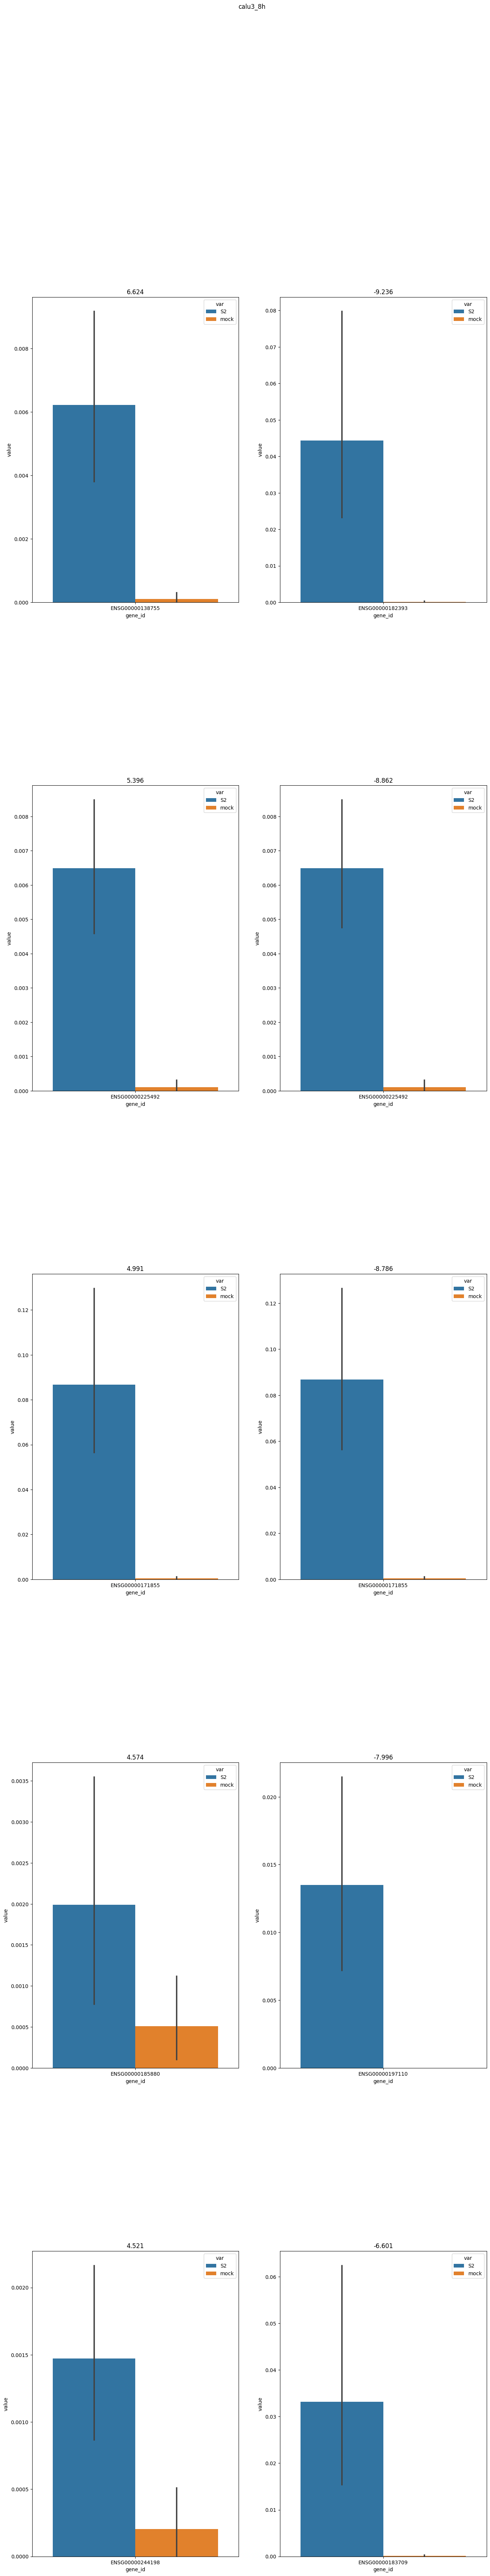

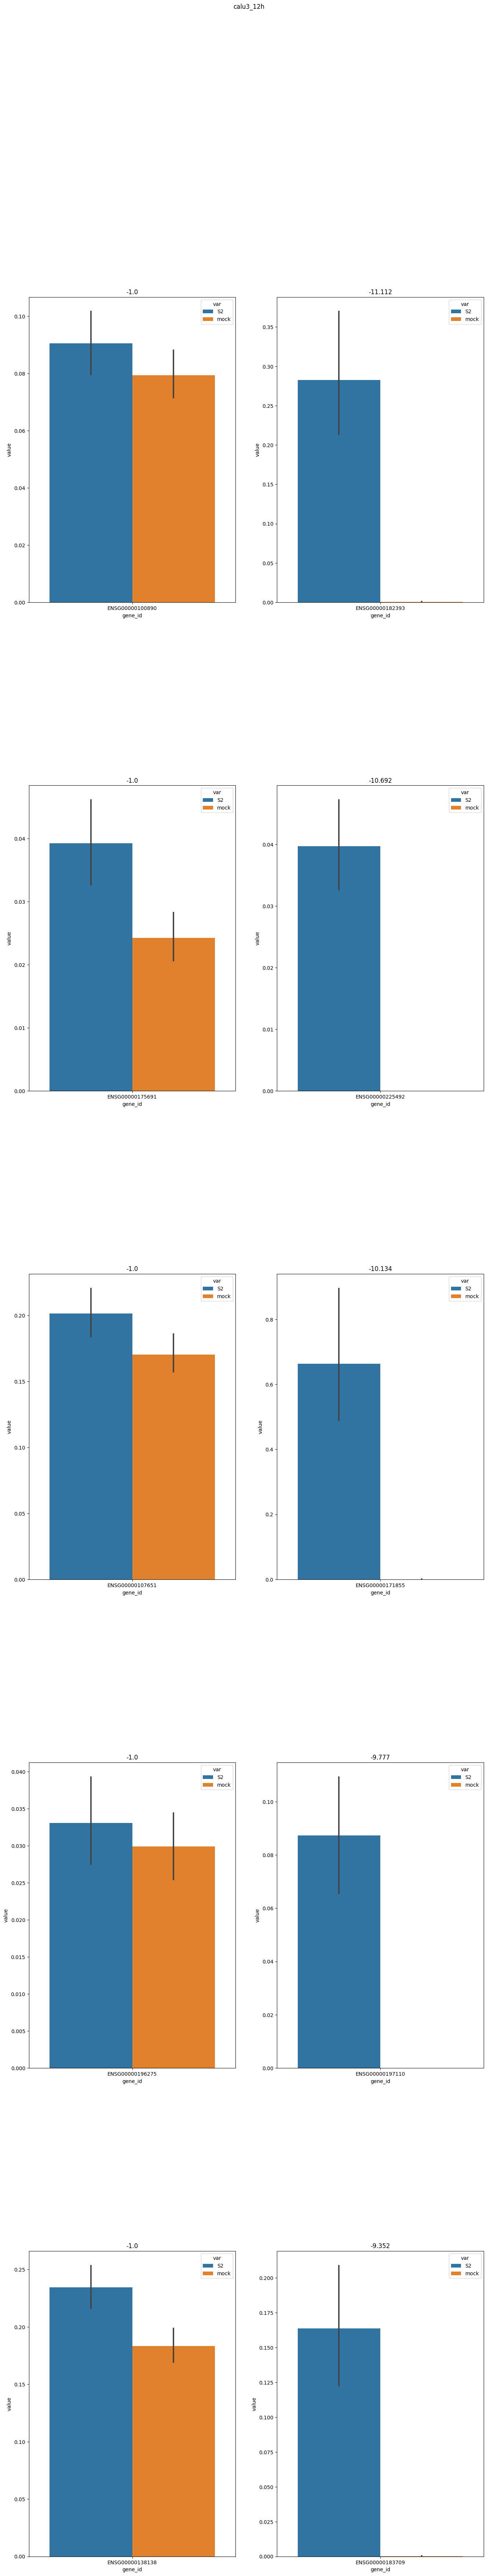

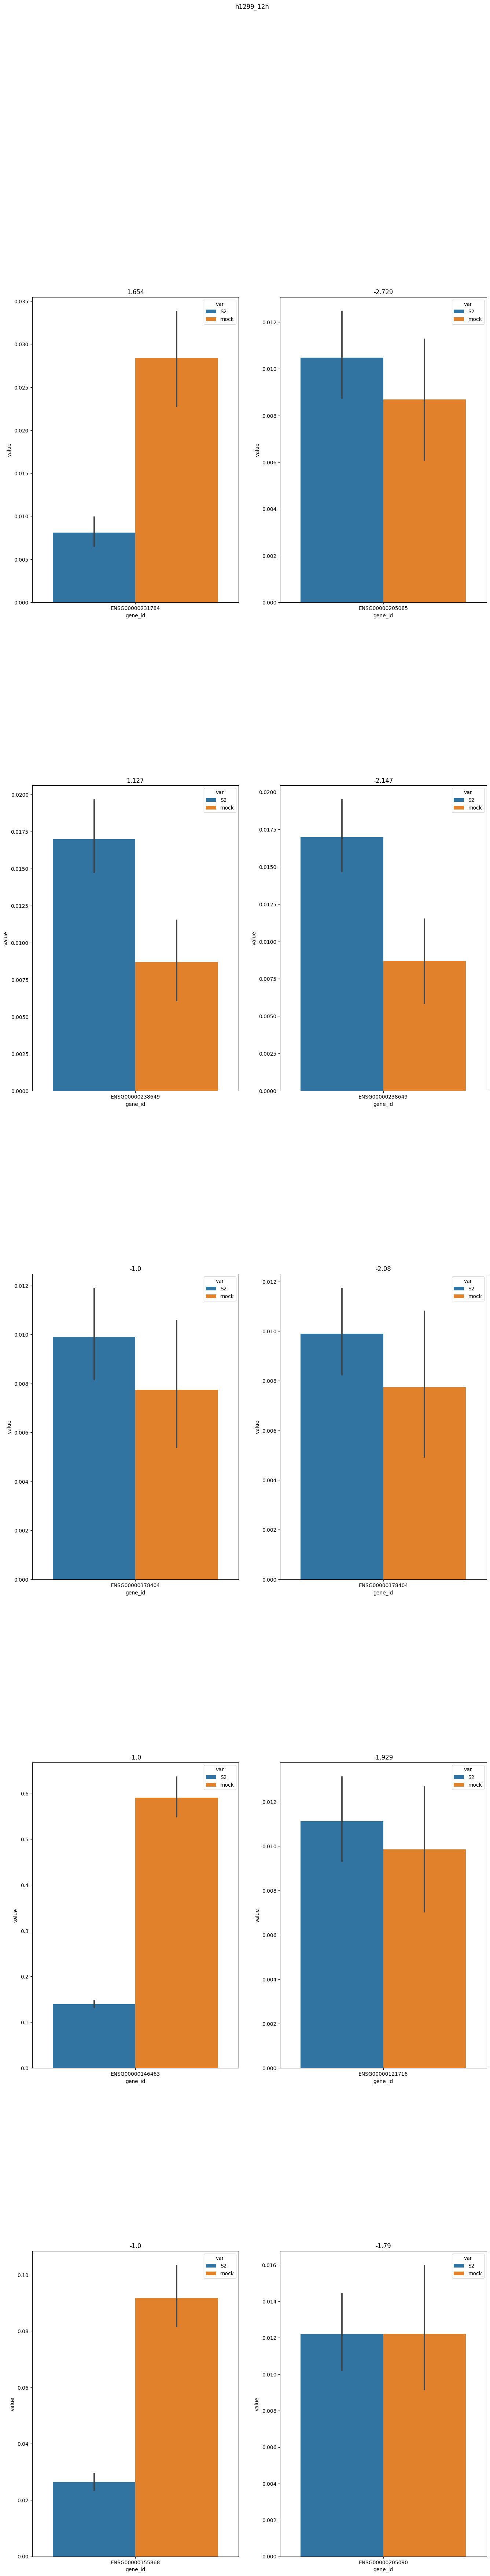

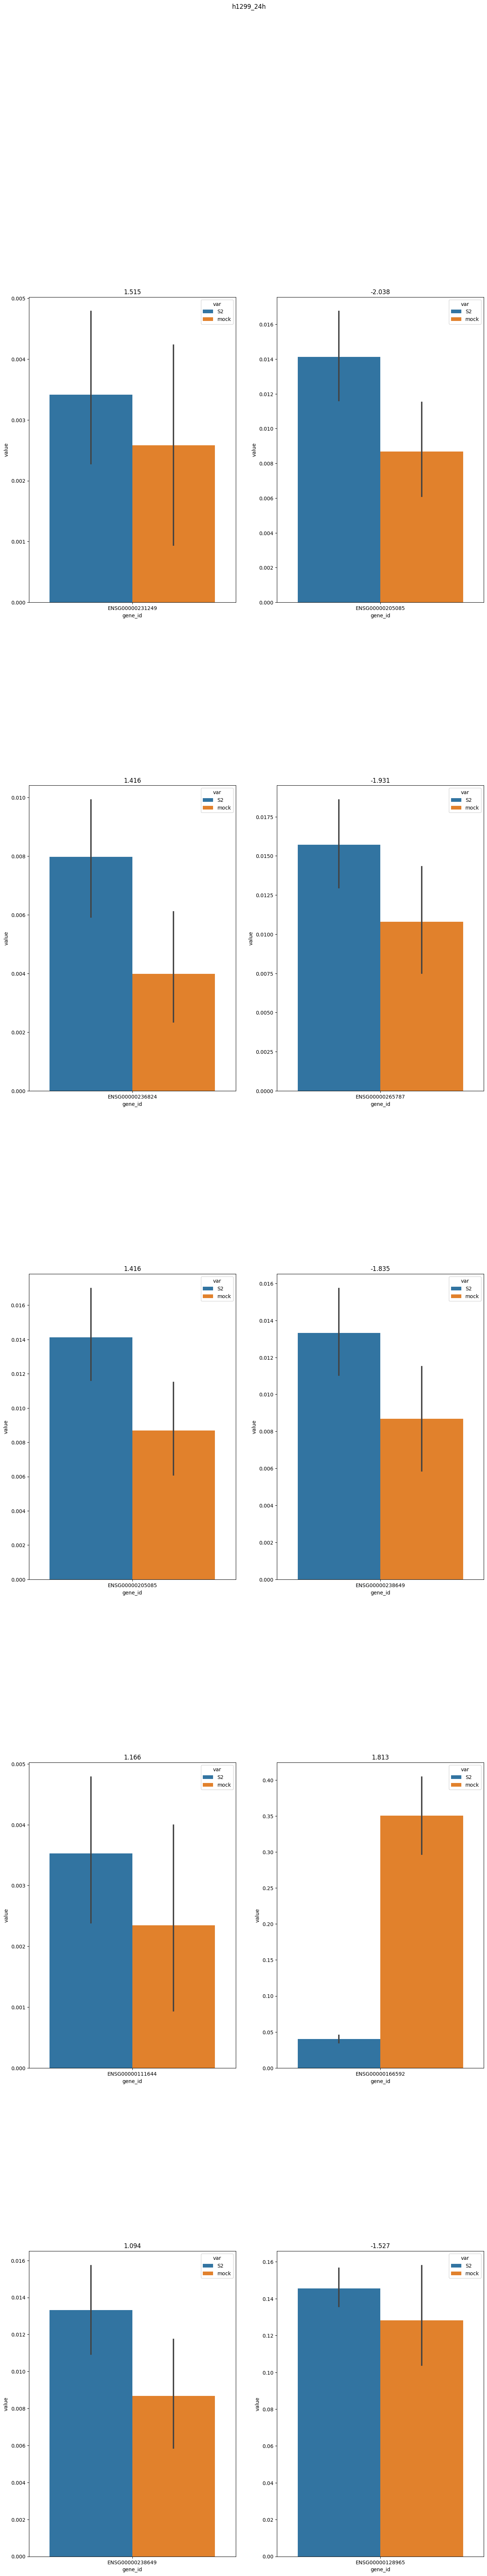

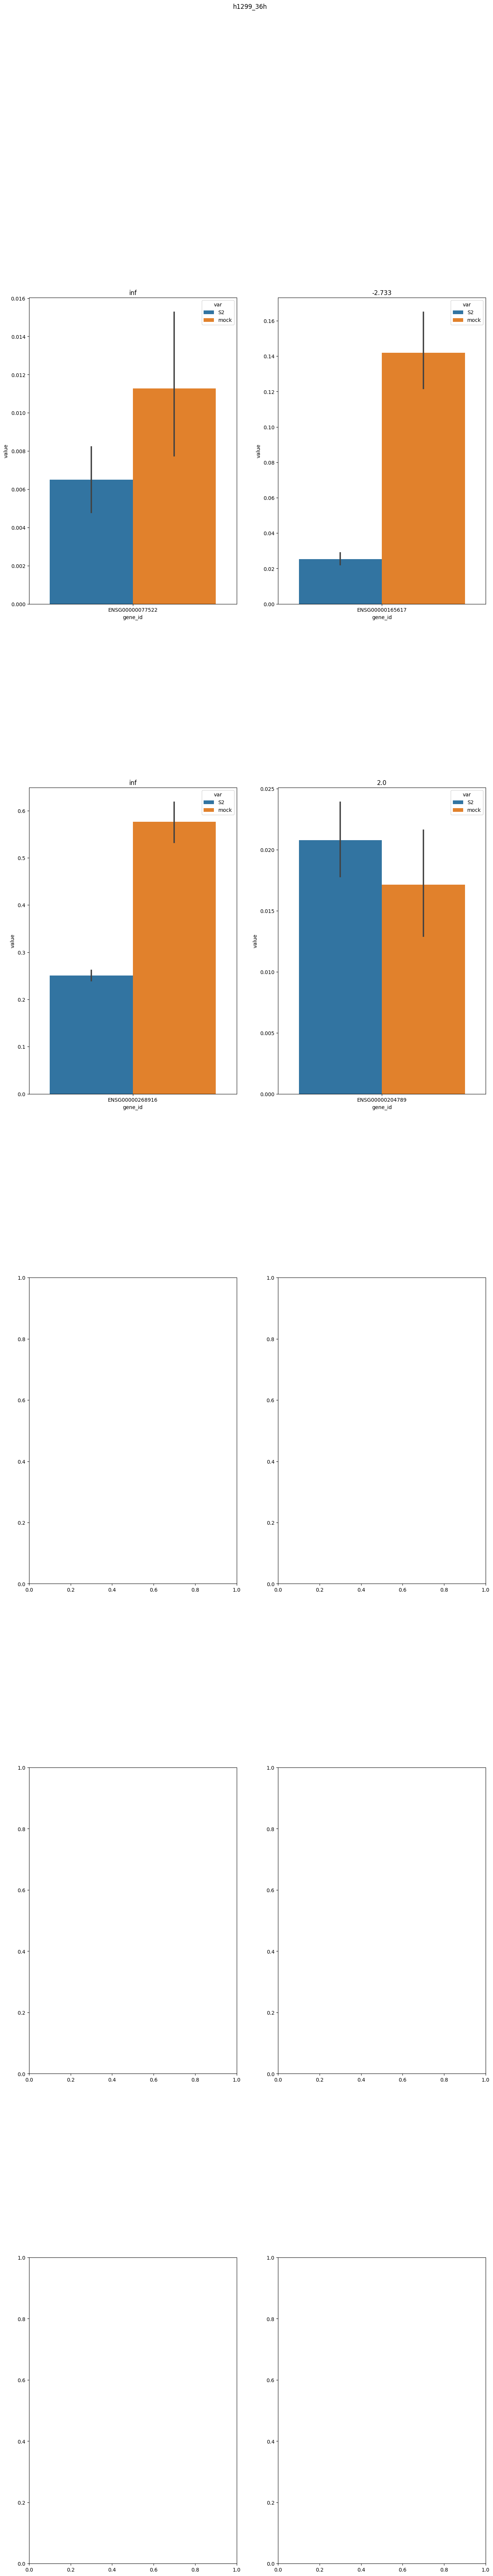

In [15]:
cell_lines_times = ['calu3_8h', 'calu3_12h', 'h1299_12h',
                    'h1299_24h', 'h1299_36h']

analyze_cell_lines(cell_lines_times)